_Neural Data Analysis_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: Artemii Shlychkov, Elias Seiffert, Arne Gittel

# Coding Lab 5



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.io as io
from typing import Union
%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

%matplotlib inline
plt.style.use("../matplotlib_style.txt")

Last updated: 2024-06-11 12:41:54Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.24.0

sklearn: 1.4.2

numpy     : 1.26.4
scipy     : 1.13.0
matplotlib: 3.8.4

Watermark: 2.4.3



## Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise. R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).      

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sample_lnp``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end simplify and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`negloglike_lnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Plot the true receptive field, a stimulus frame, the spike counts and the estimated receptive field. 

*Grading: 2 pts (calculations) + 3 pts (implementation)*

### Calculations
_You can add your calculations in_ $\LaTeX$ _here_.

$L(\omega) = \log \left( \prod_{t}^{T} \frac{r_t^{c_t}}{c_t!} e^{-r_t} \right)$

$= \sum_{t}^{T} \log r_t^{c_t} + \log e^{-r_t} - \log {c_t!} $

$= \sum_{t}^{T} \log r_t^{c_t} + r_t - \log {c_t!} $

$= \sum_{t}^{T} c_t * \log (e^{w*s_t} * \Delta t * R) - e^{w*s_t} * \Delta t * R - \log {c_t!} $

$= \sum_{t}^{T} c_t * (  w*s_t + \log (\Delta t) + \log R) - e^{w*s_t} * \Delta t * R - \log {c_t!} $


$\frac{dL(\omega)}{d\omega} = \sum_{t=1}^{T} \left( c_t s_t - s_t e^{\omega s_t} \Delta t R \right)$

### Generate data

Text(0.5, 1.0, 'Gaussian RF')

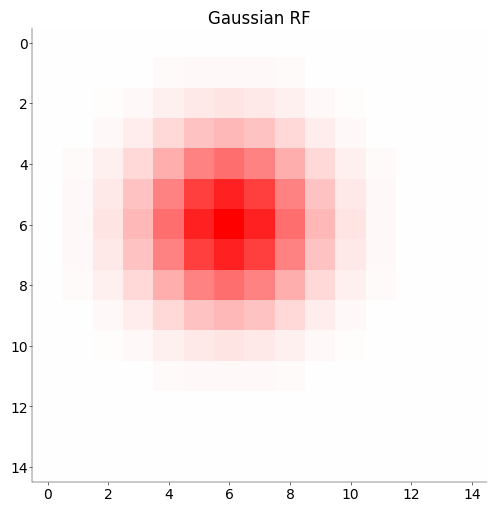

In [2]:
def gen_gauss_rf(
    D: Union[int, tuple], width: float, center: tuple = (0, 0)
) -> np.ndarray:
    """
    Generate a Gaussian receptive field.

    Args:
        D (int or tuple): Size of the receptive field (DxD) or dimensions of the receptive field (Dx, Dy).
        D (int): Size of the receptive field (DxD).
        width (float): Width parameter of the Gaussian.
        center (tuple, optional): Center coordinates of the receptive field. Defaults to (0, 0).

    Returns:
        np.ndarray: Gaussian receptive field.
    """
    if type(D) == int:

        sz = (D - 1) / 2
        x, y = np.meshgrid(np.arange(-sz, sz + 1), np.arange(-sz, sz + 1))

    elif type(D) == tuple:

        x, y = np.meshgrid(
            np.arange(-D[0] / 2, D[0] / 2), np.arange(-D[1] / 2, D[1] / 2)
        )

    x = x + center[0]
    y = y + center[1]
    w = np.exp(-(x**2 / width + y**2 / width))
    w = w / np.sum(w.flatten())

    return w


w = gen_gauss_rf(15, 7, (1, 1))

vlim = np.max(np.abs(w))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(w, cmap="bwr", vmin=-vlim, vmax=vlim)
ax.set_title("Gaussian RF")

In [3]:
def sample_lnp(
    w: np.array, nT: int, dt: float, R: float, v: float, random_seed: int = 10
):
    """Generate samples from an instantaneous LNP model neuron with
    receptive field kernel w.

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
        (flattened) receptive field kernel.

    nT: int
        number of time steps

    dt: float
        duration of a frame in s

    R: float
        rate parameter

    v: float
        variance of the flattened stimulus array

    random_seed: int
        seed for random number generator

    Returns
    -------

    c: np.array, (nT, )
        sampled spike counts in time bins

    r: np.array, (nT, )
        mean rate in time bins

    s: np.array, (Dx * Dy, nT)
        stimulus frames used

    Note
    ----

    See equations in task description above for a precise definition
    of the individual parameters.

    """

    rng = np.random.default_rng(random_seed)  # random number generator

    stimulus = rng.normal(0, np.sqrt(v), (w.size, nT))  # generate stimulus
    stimulus = stimulus

    mean_firing_rate = (
        np.exp(np.dot(w.T, stimulus)) * dt * R
    )  # compute mean firing rate
    # mean_firing_rate /= np.sum(mean_firing_rate)

    spike_count = rng.poisson(
        mean_firing_rate
    )  # generate spike counts from Poisson distribution with rate mean_firing_rate

    # insert your code here

    # ------------------------------------------------
    # Generate samples from an instantaneous LNP model
    # neuron with receptive field kernel w. (0.5 pts)
    # ------------------------------------------------

    return spike_count, mean_firing_rate, stimulus

In [4]:
D = 15  # number of pixels
nT = 1000  # number of time bins
dt = 0.1  # bins of 100 ms
R = 50  # firing rate in Hz
v = 20  # stimulus variance

w = gen_gauss_rf(D, 7, (1, 1))  # generate receptive field
w = w.flatten()
print(w.shape)
print(w.size)

c, r, s = sample_lnp(w, nT, dt, R, v)  # generate samples
print(c.shape, r.shape, s.shape)

(225,)
225
(1000,) (1000,) (225, 1000)


Text(0, 0.5, 'Spike count')

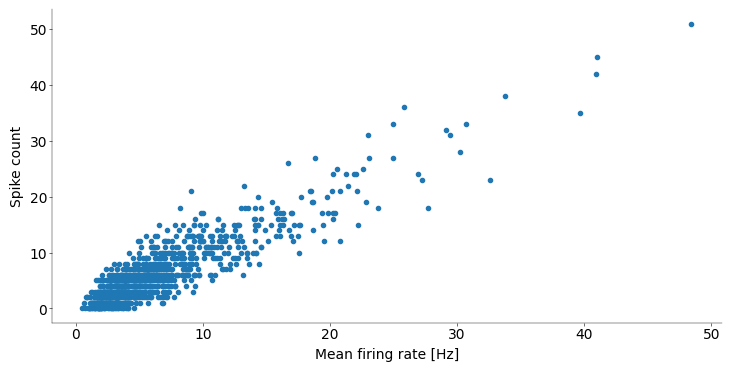

In [5]:
plt.scatter(r, c)
plt.xlabel("Mean firing rate [Hz]")
plt.ylabel("Spike count")

Plot the stimulus for one frame, the cell's response over time and the spike count vs firing rate.

Text(0, 0.5, 'Count')

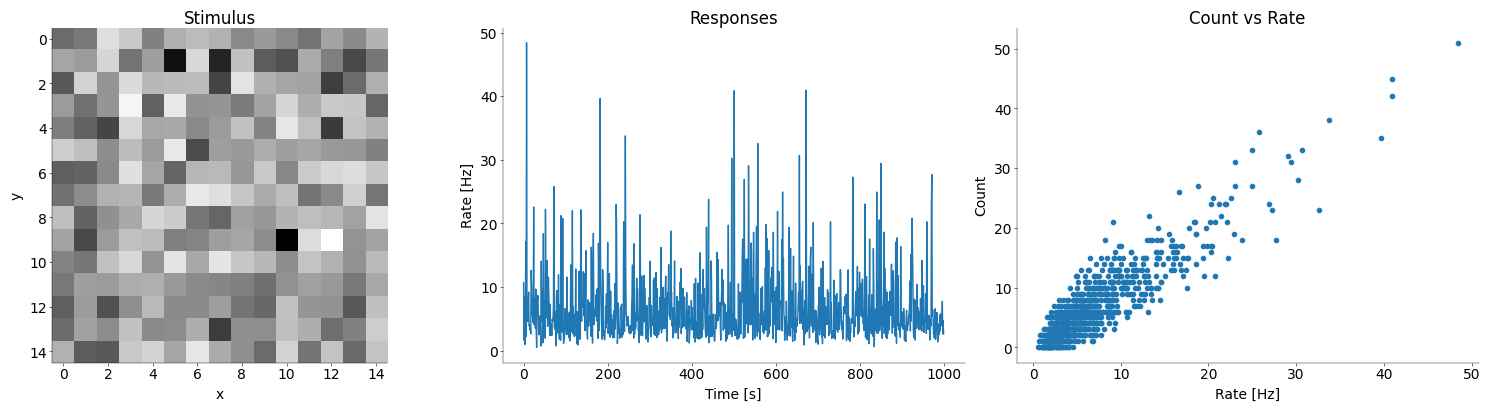

In [6]:
mosaic = mosaic = [["stim", "responses", "count/rate"]]

fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(15, 4))
# -----------------------------------------------------------------------------------------------------------
# Plot the stimulus for one frame, the cell's responses over time and spike count vs firing rate (0.5 points)
# -----------------------------------------------------------------------------------------------------------

ax["stim"].imshow(s[:, 0].reshape(D, D), cmap="gray")
ax["stim"].set_title("Stimulus")
ax["stim"].set_xlabel("x")
ax["stim"].set_ylabel("y")

ax["responses"].plot(r)
ax["responses"].set_title("Responses")
ax["responses"].set_xlabel("Time [s]")
ax["responses"].set_ylabel("Rate [Hz]")

ax["count/rate"].scatter(r, c)
ax["count/rate"].set_title("Count vs Rate")
ax["count/rate"].set_xlabel("Rate [Hz]")
ax["count/rate"].set_ylabel("Count")

### Implementation 

Implement the negative log-likelihood of the LNP and its gradient with respect to the receptive field using the simplified equations you calculated earlier _(0.5 pts)_

In [7]:
import math
from scipy.special import factorial


def negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> float:
    """Implements the negative (!) log-likelihood of the LNP model

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
      current receptive field

    c: np.array, (nT, )
      spike counts

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at w

    """

    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # ------------------------------------------------
    r = np.exp(w.T @ s) * dt * R  # mean firing rate

    f = -np.sum(c * np.log(r) - r - np.log(factorial(c)))  # negative log likelihood

    return f


def deriv_negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> np.array:
    """Implements the gradient of the negative log-likelihood of the LNP model

    Parameters
    ----------

    see negloglike_lnp

    Returns
    -------

    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to w

    """

    grad = np.sum(
        (r - c) * s, axis=1
    )  # gradient of the negative log likelihood (looks a bit weird to me compared to the by-hand calculation, but I think it's correct)

    return grad

In [8]:
log_likelihood = negloglike_lnp(w, c, s)  # compute the negative log likelihood
print("log_likelihood =", log_likelihood)

log_likelihood = 2251.962531737988


The helper function `check_grad` in `scipy.optimize` can help you to make sure your equations and implementations are correct. It might be helpful to validate the gradient before you run your optimizer.

In [9]:
# Check gradient
# insert your code here
grad = deriv_negloglike_lnp(w, c, s)

print("Error:", opt.check_grad(negloglike_lnp, deriv_negloglike_lnp, w, c, s))

Error: 0.015142765119154983


Fit receptive field maximizing the log likelihood.

The scipy.optimize package also has suitable functions for optimization. If you generate a large number of samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

In [10]:
# insert your code here
w = gen_gauss_rf(D, 7, (1, 1)).flatten()  # generate a receptive field
# ------------------------------------------
# Estimate the receptive field by maximizing
# the log-likelihood (or more commonly,
# minimizing the negative log-likelihood).
#
# Tips: use scipy.optimize.minimize(). (1 pt)
# ------------------------------------------
w_opt = opt.minimize(
    negloglike_lnp, w, args=(c, s)
).x  # estimate the receptive field by minimizing the negative log-likelihood

Text(0.5, 1.0, 'Estimated receptive field')

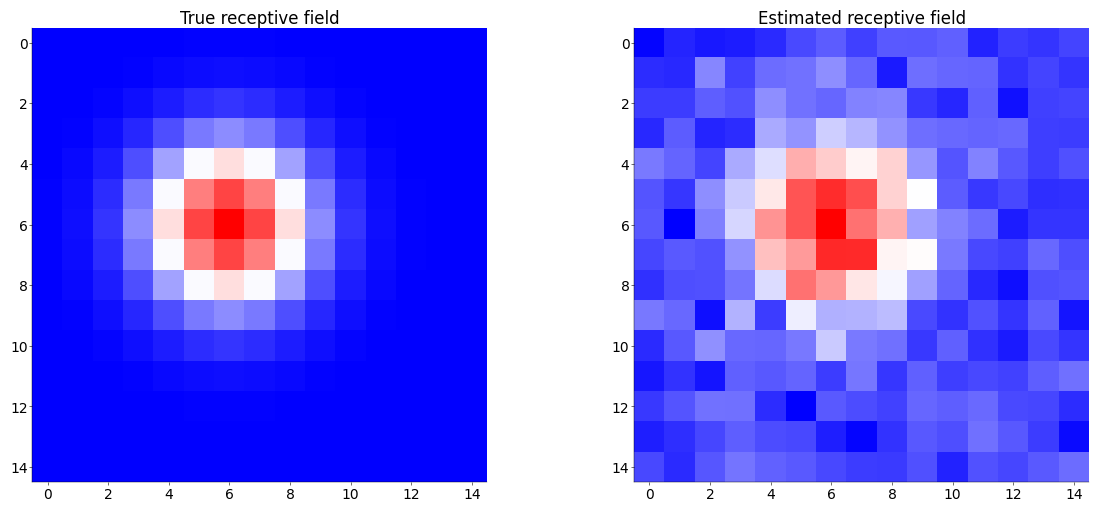

In [11]:
# insert your code here

# ------------------------------------
# Plot the ground truth and estimated
# `w` side by side. (0.5 pts)
# ------------------------------------

mosaic = [["True", "Estimated"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12, 5))

ax["True"].imshow(w.reshape(D, D), cmap="bwr")
ax["True"].set_title("True receptive field")

ax["Estimated"].imshow(w_opt.reshape(D, D), cmap="bwr")
ax["Estimated"].set_title("Estimated receptive field")


# make sure to add a colorbar. 'bwr' is a reasonable choice for the cmap.

## Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nds_cl_5_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). 
* Plot the resulting filters

*Grading: 2 pts*


In [12]:
var = io.loadmat("../data/nds_cl_5_data.mat")  # load the data

# t contains the spike times of the neuron
t = var["DN_spiketimes"].flatten()

# trigger contains the times at which the stimulus flipped
trigger = var["DN_triggertimes"].flatten()
print(trigger.shape)

# contains the stimulus movie with black and white pixels
s = var["DN_stim"]
s = s.reshape((300, 1500))  # the shape of each frame is (20, 15)
s = s[:, 1 : len(trigger)]

(1489,)


Create vector of spike counts

(1488,)


Text(0.5, 1.0, 'Spike count vs time')

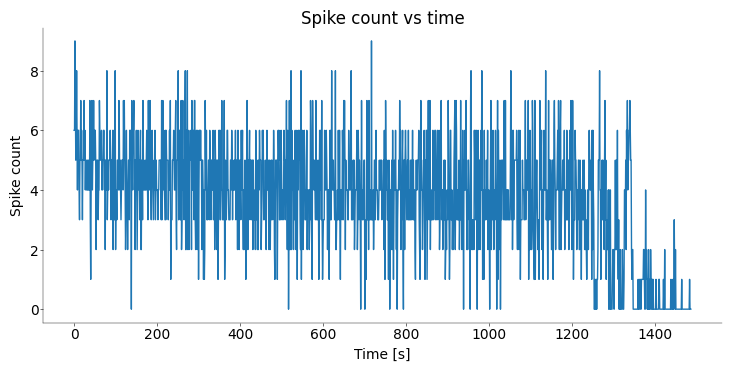

In [13]:
# insert your code here

spike_counts = np.histogram(t, bins=trigger)[0]  # bin the spike times
print(spike_counts.shape)


# ------------------------------------------
# Bin the spike counts at the same temporal
# resolution as the stimulus (0.5 pts)
# ------------------------------------------
plt.plot(spike_counts)  # plot the spike counts
plt.xlabel("Time [s]")
plt.ylabel("Spike count")
plt.title("Spike count vs time")

#### Fit receptive field for each frame separately (Note: this may take up to 30 mins)

In [14]:
# insert your code here
deltas = [0, 1, 2, 3, 4]  # time lags
w = gen_gauss_rf(
    (15, 20), 7, (1, 1)
).flatten()  # generate a receptive field concordant with the stimulus size
# w = np.pad(w, (0, 75), "constant")
print("RF shape:", w.shape)
print("Stimulus shape:", s.shape)
# print(spike_counts.shape)
w_opt_lag_1 = np.zeros(
    (w.size, len(deltas))
)  # initialize the estimated receptive fields

# estimate the receptive field by minimizing the negative log-likelihood with the current time lag


for delta in deltas:
    # print(w.shape, spike_counts[delta:].shape, s[:, :-delta].shape)
    if delta == 0:
        w_opt_lag_1[:, delta] = opt.minimize(
            negloglike_lnp, w, args=(spike_counts[delta:], s)
        ).x
    else:
        w_opt_lag_1[:, delta] = opt.minimize(
            negloglike_lnp, w, args=(spike_counts[delta:], s[:, :-delta])
        ).x

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (1 pt)
#
# The final receptive field (`w_hat`) should
# be in the shape of (Dx * Dy, 5)
# ------------------------------------------


# insert your code here

RF shape: (300,)
Stimulus shape: (300, 1488)


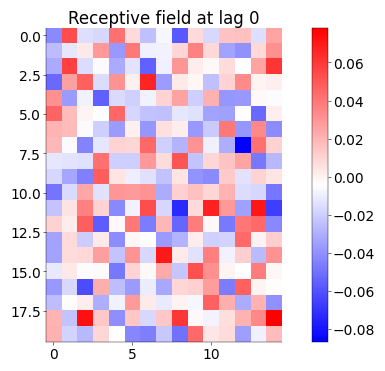

In [ ]:
plt.imshow(np.reshape(w_opt_lag_1[:, 0], (20, 15)), cmap="bwr")
plt.title("Receptive field at lag 0")

# create colorbar
plt.colorbar()

Plot the frames one by one

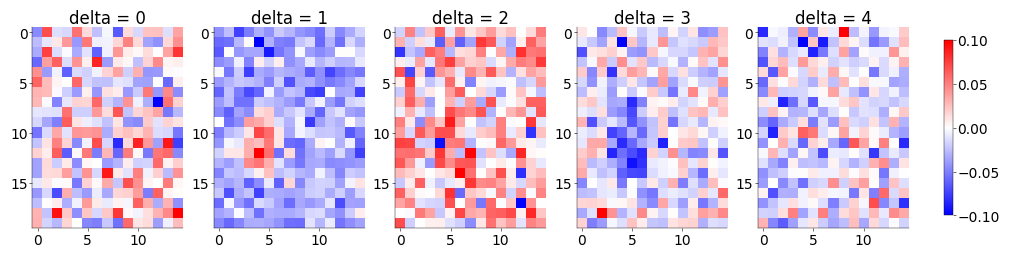

In [ ]:
# insert your code here

# --------------------------------------------
# Plot all 5 frames of the fitted RFs (0.5 pt)
# --------------------------------------------
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


fig, ax = plt.subplots(1, 5, figsize=(10, 10), constrained_layout=True)
for i, delta in enumerate(deltas):

    ax[i].imshow(np.reshape(w_opt_lag_1[:, i], (20, 15)), cmap="bwr")
    ax[i].set_title(f"delta = {delta}")
    # create colorbar
sm = ScalarMappable(norm=Normalize(vmin=-0.1, vmax=0.1), cmap="bwr")
sm.set_array([])
plt.colorbar(sm, ax=ax, fraction=0.01, pad=0.04)

## Task 3: Separate space/time components

The receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them, both are independent and the resulting spatio-temporal component is thus called separable. As discussed in the lecture, you can use singular-value decomposition to separate these two: 

$$
W = u_1 s_1 v_1^T
$$

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.

*Grading: 1 pts*

Text(0, 0.5, 'Amplitude')

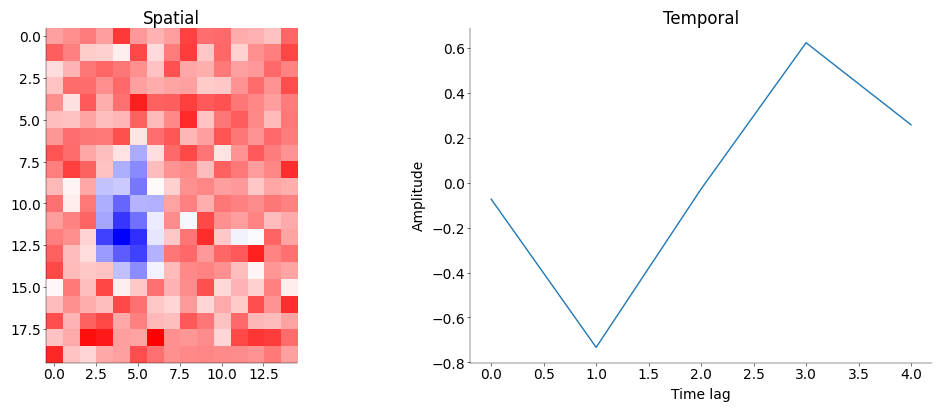

In [ ]:
# insert your code here

# --------------------------------------------
# Apply SVD to the fitted receptive field,
# you can use either numpy or sklearn (0.5 pt)
# --------------------------------------------

# shape of w_hat: (300,5).
# subtract mean along axis=1 (time) since for every timelag the RF is estimated independently
for i in range(w_opt_lag_1.shape[1]):
    w_opt_lag_1[:, i] -= np.mean(w_opt_lag_1, axis=1)

U, S, V = np.linalg.svd(w_opt_lag_1)

# -------------------------------------------------
# Plot the spatial and temporal components (0.5 pt)
# -------------------------------------------------

fig, ax = plt.subplot_mosaic(
    mosaic=[["Spatial", "Temporal"]], figsize=(10, 4), constrained_layout=True
)

ax["Spatial"].imshow(np.reshape(U[:, 0], (20, 15)), cmap="bwr")
ax["Spatial"].set_title("Spatial")

timelime = np.linspace(0, 4, 5)
ax["Temporal"].plot(timelime, V[0, :])
ax["Temporal"].set_title("Temporal")
ax["Temporal"].set_xlabel("Time lag [s]")
ax["Temporal"].set_ylabel("Amplitude")


# add plot

## Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

If you want to keep the Poisson noise model, you can use the implementation in [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet). Otherwise, you can also resort to the linear model from `sklearn` which assumes Gaussian noise (which in my hands was much faster).

*Grading: 2 pts*


In [ ]:
from sklearn import linear_model

# insert your code here

# model = linear_model.ridge_regression(w_opt_lag, spike_counts, alpha=1)

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (the same as before)
# with sklern or pyglmnet (1 pt)
# ------------------------------------------
w = gen_gauss_rf(15, 7, (1, 1)).flatten()
w = np.pad(w, (0, 75), "constant")


delta = [0, 1, 2, 3, 4]
w_opt_lag = np.zeros((w.size, len(deltas)))


# If one wants to use cross-validation to find the optimal alpha

# alphas = np.linspace(0.005, 0.1, 1000)
# model = linear_model.LassoCV(alphas=alphas, verbose=1, n_jobs=-1)

model = linear_model.Lasso(alpha=0.01, max_iter=10000)


for i, delta in enumerate(deltas):
    if delta == 0:
        model.fit(s.T, spike_counts)

    else:
        model.fit(s[:, :-delta].T, spike_counts[delta:])
    w_opt_lag[:, i] = model.coef_
    # print("optimal alphja =", model.alpha_)

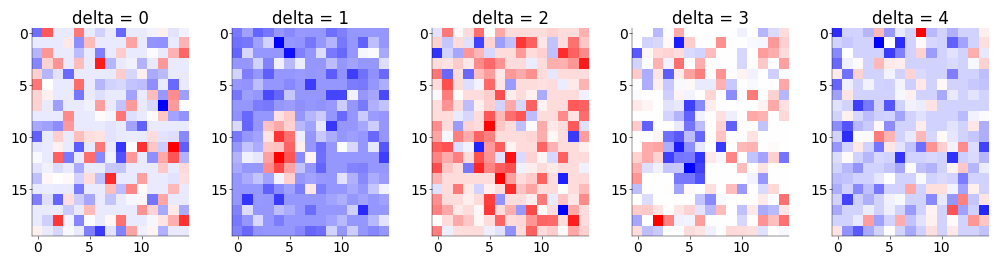

In [ ]:
# ------------------------------------------
# plot the estimated receptive fields (1 pt)
# ------------------------------------------
delta = [0, 1, 2, 3, 4]
fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10, 4), constrained_layout=True)
# add plot
for i, delta in enumerate(deltas):
    ax[delta].imshow(np.reshape(w_opt_lag[:, i], (20, 15)), cmap="bwr")
    ax[delta].set_title(f"delta = {delta}")
plt.show()
# create colorbar